# Pipeline Performance Analysis


### Load necessary libraries and inputs

In [ ]:
# install.packages("ggExtra")
# install.packages("lubridate")
# install.packages("patchwork")
# install.packages("tidyr")

Installing package into ‘/home/bia/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [ ]:
library(ggplot2)     # For creating plots
library(dplyr)       # For data manipulation
library(tidyr)       # For reshaping data
library(ggExtra)     # For adding marginal histograms
library(lubridate)   # For date manipulation
library(patchwork)   # For combining plots
library(stringr)     # For string manipulation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## General Data Preprocessing and Cleaning

In [10]:
# Read the trace data from a tab-delimited file
trace_data <- read.delim("trace.txt", sep = "\t",
                         header = TRUE, stringsAsFactors = FALSE)
head(trace_data)

# Filter the data to include only completed processes
trace_data_processed <- trace_data %>% filter(status == "COMPLETED")

# Separate the 'name' column into 'process' and 'id'
trace_data_processed <- trace_data_processed %>%
  separate(name, into = c("process", "id"),
           sep = " \\(", extra = "merge", remove = FALSE) %>%
  mutate(id = gsub("\\)", "", id))

head(trace_data_processed)

,task_id,hash,native_id,name,status,exit,submit,duration,realtime,X.cpu,peak_rss,peak_vmem,rchar,wchar
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2,29/eca55d,4036,getReadFTP (1),COMPLETED,0,2025-02-17 15:34:27.008,18.6s,14.7s,5.2%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
2,4,bd/19bd15,4031,getReadFTP (3),COMPLETED,0,2025-02-17 15:34:26.979,18.7s,14.7s,5.3%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
3,3,6f/d7e65f,6065,getReadFTP (2),COMPLETED,0,2025-02-17 15:34:45.732,5.4s,5.1s,9.6%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
4,6,3b/e37ae2,6056,getReadFTP (5),COMPLETED,0,2025-02-17 15:34:45.706,5.5s,5.2s,9.5%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
5,5,61/9946f0,7606,getReadFTP (4),COMPLETED,0,2025-02-17 15:34:51.198,41.4s,6s,7.7%,28.2 MB,274.7 MB,4.2 MB,5.8 KB
6,1,69/86dce2,4027,genomeGenerateSTAR,COMPLETED,0,2025-02-17 15:34:26.936,2m 59s,2m 52s,114.0%,3.1 GB,4.9 GB,2.2 GB,4.4 GB


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1 rows [6].”


,task_id,hash,native_id,name,process,id,status,exit,submit,duration,realtime,X.cpu,peak_rss,peak_vmem,rchar,wchar
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2,29/eca55d,4036,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-02-17 15:34:27.008,18.6s,14.7s,5.2%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
2,4,bd/19bd15,4031,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-02-17 15:34:26.979,18.7s,14.7s,5.3%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
3,3,6f/d7e65f,6065,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-02-17 15:34:45.732,5.4s,5.1s,9.6%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
4,6,3b/e37ae2,6056,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-02-17 15:34:45.706,5.5s,5.2s,9.5%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
5,5,61/9946f0,7606,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-02-17 15:34:51.198,41.4s,6s,7.7%,28.2 MB,274.7 MB,4.2 MB,5.8 KB
6,1,69/86dce2,4027,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-02-17 15:34:26.936,2m 59s,2m 52s,114.0%,3.1 GB,4.9 GB,2.2 GB,4.4 GB


## Resource Consumption Over Time

#### Data processing

In [11]:
library(stringr)
library(dplyr)

# Convert the duration to seconds function
convert_to_seconds <- function(time_str) {
  time_str <- gsub("h", "H", time_str)
  time_str <- gsub("m", "M", time_str)
  time_str <- gsub("s", "S", time_str)
  duration <- lubridate::as.duration(time_str)
  seconds <- as.numeric(duration, "seconds")

  seconds
}

# Remove the "%" sign and convert to numeric
convert_cpu <- function(cpu) {
  cpu_value <- as.numeric(str_remove(cpu, "%"))

  cpu_value
}

# Function to convert memory string to numeric value in MB
clean_memory_column <- function(column) {
  value <- as.numeric(gsub("[^0-9.]", "", column)) # nolint
  unit <- gsub("[0-9. ]", "", column) # nolint

  value_mb <- case_when(
    unit == "KB" ~ value / 1024,  # Convert KB to MB
    unit == "MB" ~ value,         # Keep MB as is
    unit == "GB" ~ value * 1024,  # Convert GB to MB
    TRUE ~ NA_real_               # Handle unexpected units
  )

  value_mb
}

trace_data_processed <- trace_data_processed %>%
  mutate(submit = ymd_hms(submit),  # Convert 'submit' to datetime
         duration_sec = convert_to_seconds(duration), # Convert to seconds
         end_time = submit + seconds(duration_sec),  # Calculate end time
         cpu_percent = convert_cpu(X.cpu),   # Convert %cpu to numeric
         peak_rss_mb = clean_memory_column(peak_rss))  # Convert memory to MB

# Create a sequence of minutes
duration_by_minute <- seq(from = min(trace_data_processed$submit),
                    to = max(trace_data_processed$end_time),
                    by = "1 min")

# Calculate total CPU and memory usage for each minute
resources_by_minute <- data.frame(full_time = duration_by_minute) %>%
  rowwise() %>%
  mutate(
    cpu_total = sum(
      trace_data_processed$cpu_percent[trace_data_processed$submit
      <= full_time & trace_data_processed$end_time >= full_time], # nolint
      na.rm = TRUE
    ),
    mem_total = sum(
      trace_data_processed$peak_rss_mb[trace_data_processed$submit
      <= full_time & trace_data_processed$end_time >= full_time], # nolint
      na.rm = TRUE
    )
  )
# Create a minute index column
resources_by_minute$minute <- seq(0, nrow(resources_by_minute) - 1)

head(resources_by_minute)


full_time,cpu_total,mem_total,minute
<dttm>,<dbl>,<dbl>,<int>
2025-02-17 15:34:26,114,3174.4,0
2025-02-17 15:35:26,136,3251.8,1
2025-02-17 15:36:26,131,3235.9,2
2025-02-17 15:37:26,17,61.5,3
2025-02-17 15:38:26,17,61.5,4
2025-02-17 15:39:26,17,61.5,5


### Plot generation: CPU and Memory consumption over time

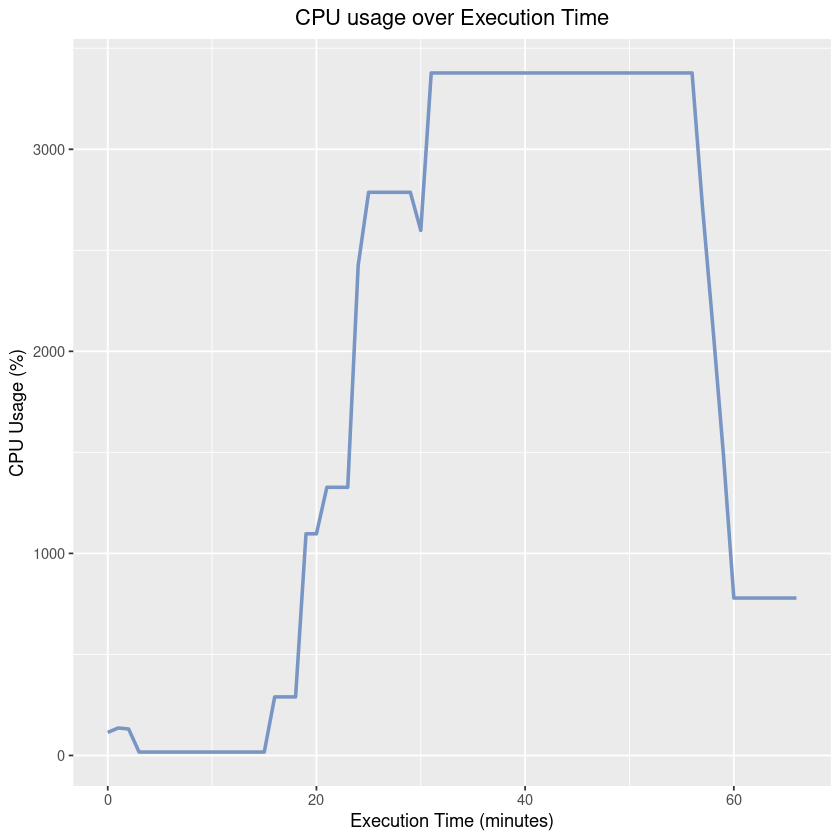

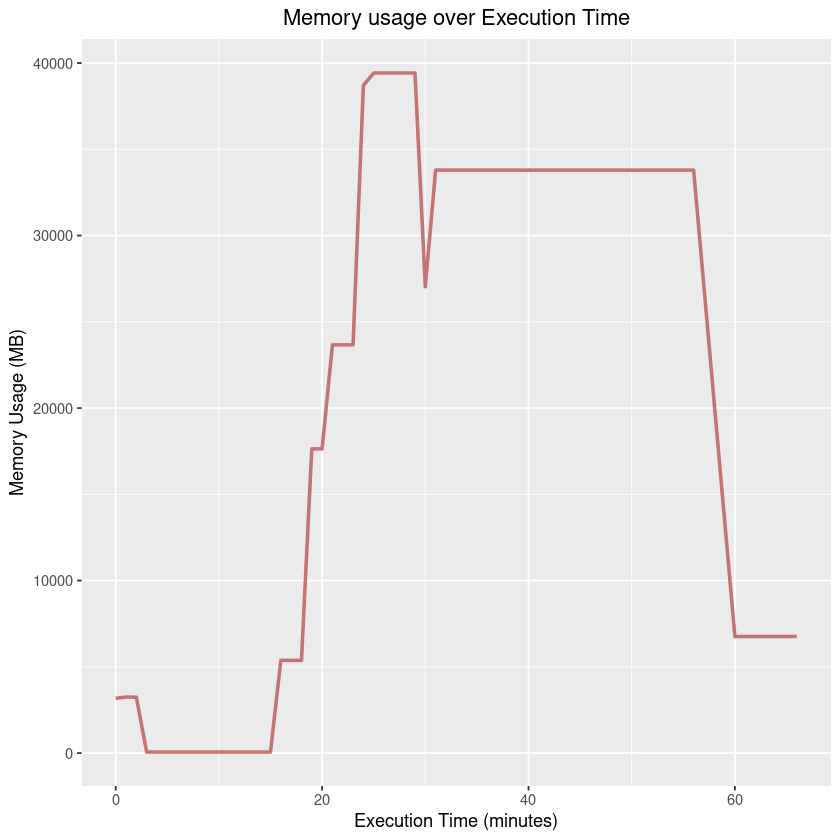

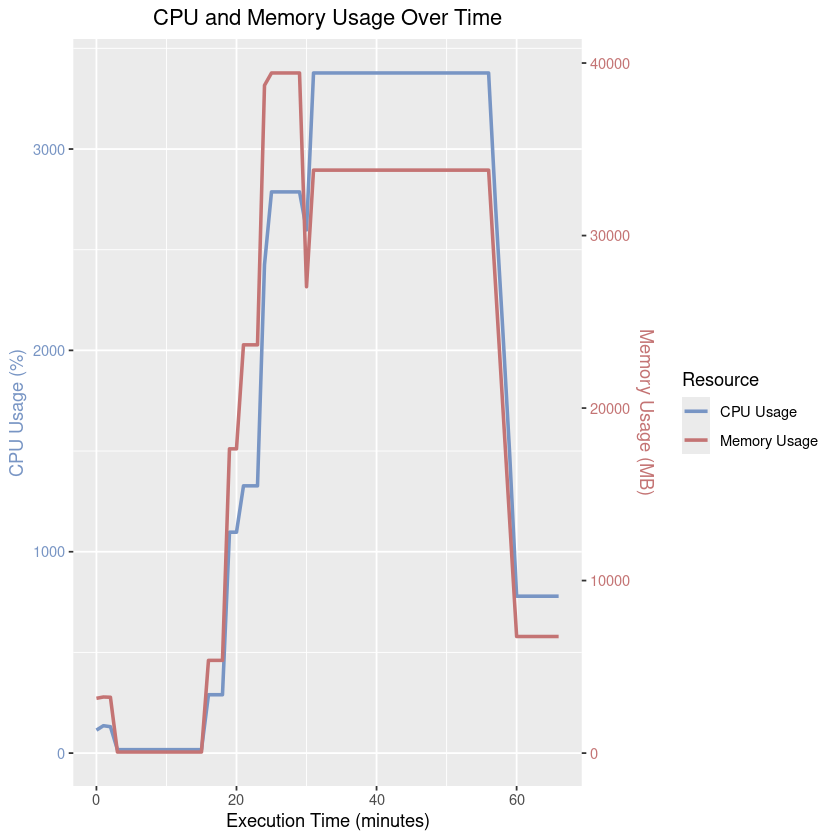

In [12]:
# CPU % Usage over time
cpu_over_time <- ggplot(resources_by_minute, aes(x = minute, y = cpu_total)) +
  geom_line(color = "#7895c4", linewidth = 1) +
  labs(
    title = "CPU usage over Execution Time",
    x = "Execution Time (minutes)",
    y = "CPU Usage (%)"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) 

cpu_over_time

# Memory MB Usage over time
mem_over_time <- ggplot(resources_by_minute, aes(x = minute, y = mem_total)) +
  geom_line(color = "#c47474", linewidth = 1) +
  labs(
    title = "Memory usage over Execution Time",
    x = "Execution Time (minutes)",
    y = "Memory Usage (MB)"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) 

mem_over_time

scaling_factor <- max(resources_by_minute$mem_total) /
  max(resources_by_minute$cpu_total)


# Resource Usage Over Time
resources_over_time <- ggplot(resources_by_minute) +
  geom_line(
    aes(x = minute, y = cpu_total, color = "CPU Usage"),
    linewidth = 1
  ) +
  geom_line(
    aes(x = minute, y = mem_total / scaling_factor, color = "Memory Usage"),
    linewidth = 1
  ) +
  # Dual y-axes
  scale_y_continuous(
    name = "CPU Usage (%)",
    sec.axis = sec_axis(
      ~ . * scaling_factor,  
      name = "Memory Usage (MB)"
    )
  ) +
  scale_x_continuous(
    name = "Execution Time (minutes)", 
    breaks = seq(0, max(resources_by_minute$minute), by = 20)
  ) +
  scale_color_manual(
    values = c("CPU Usage" = "#7895c4", "Memory Usage" = "#c47474")
  ) +
  labs(
    color = "Resource",
    title = "CPU and Memory Usage Over Time"
  ) +
  theme_gray() +
  theme(
        legend.position = "right",
        axis.title.y.right = element_text(color = "#c47474"),
        axis.text.y.right = element_text(color = "#c47474"),
        axis.title.y.left = element_text(color = "#7895c4"),
        axis.text.y.left = element_text(color = "#7895c4"),
        plot.title = element_text(hjust = 0.5))

print(resources_over_time)


## Resources and Parallelism Analysis 

#### Data processing

In [14]:
# Calculate the start and end times in minutes from the minimum submit time
trace_data_processed <- trace_data_processed %>%
  mutate(
    start_minutes = as.numeric(difftime(submit, min(submit), units = "mins")),
    end_minutes = as.numeric(difftime(end_time, min(submit), units = "mins"))
  )

head(trace_data_processed)

,task_id,hash,native_id,name,process,id,status,exit,submit,duration,⋯,peak_rss,peak_vmem,rchar,wchar,duration_sec,end_time,cpu_percent,peak_rss_mb,start_minutes,end_minutes
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,29/eca55d,4036,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-02-17 15:34:27,18.6s,⋯,28.1 MB,273.7 MB,4.2 MB,5.8 KB,18.6,2025-02-17 15:34:45,5.2,28.1,0.0012000004,0.3112000
2,4,bd/19bd15,4031,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-02-17 15:34:26,18.7s,⋯,28.1 MB,273.7 MB,4.2 MB,5.8 KB,18.7,2025-02-17 15:34:45,5.3,28.1,0.0007166704,0.3123833
3,3,6f/d7e65f,6065,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-02-17 15:34:45,5.4s,⋯,28.1 MB,273.7 MB,4.2 MB,5.8 KB,5.4,2025-02-17 15:34:51,9.6,28.1,0.3132666667,0.4032667
4,6,3b/e37ae2,6056,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-02-17 15:34:45,5.5s,⋯,28.1 MB,273.7 MB,4.2 MB,5.8 KB,5.5,2025-02-17 15:34:51,9.5,28.1,0.3128333330,0.4045000
5,5,61/9946f0,7606,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-02-17 15:34:51,41.4s,⋯,28.2 MB,274.7 MB,4.2 MB,5.8 KB,41.4,2025-02-17 15:35:32,7.7,28.2,0.4043666681,1.0943667
6,1,69/86dce2,4027,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-02-17 15:34:26,2m 59s,⋯,3.1 GB,4.9 GB,2.2 GB,4.4 GB,179.0,2025-02-17 15:37:25,114.0,3174.4,0.0000000000,2.9833333


### Plot Generation: Parallelism and Resource Consumption

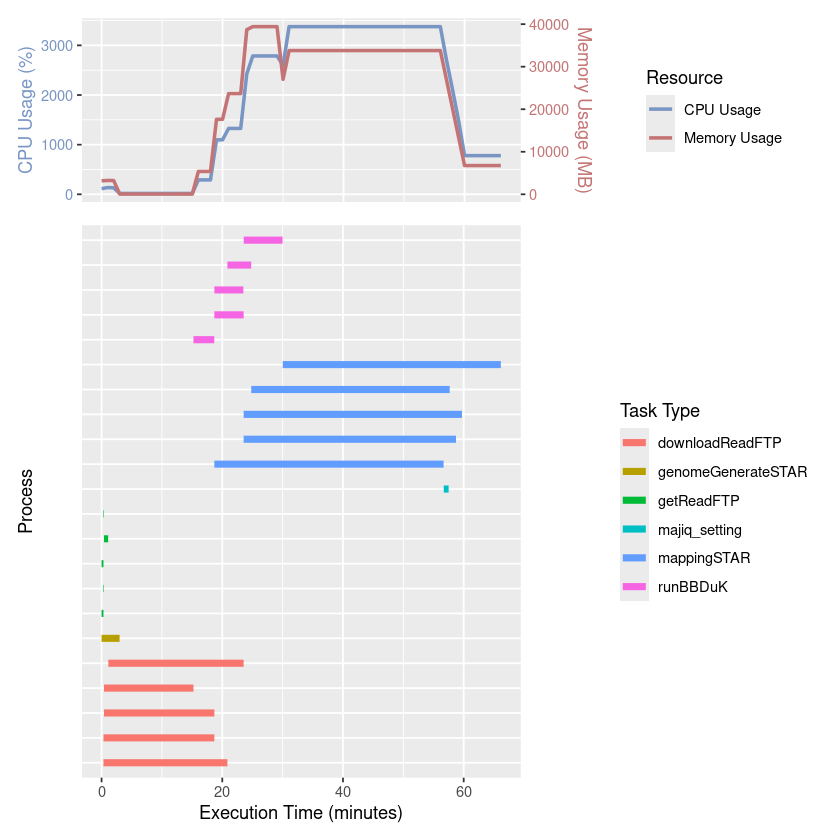

In [16]:
# Edit the CPU and Memory usage plot to remove title and x-axis elements
cpu_mem_edit <- resources_over_time +
  theme(
    plot.title = element_blank(),
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    axis.ticks.x = element_blank()
  )

# Create a Gantt chart to visualize the process execution times
gantt_plot <- ggplot(trace_data_processed) +
  geom_segment(
    aes(
      x = start_minutes,
      xend = end_minutes,
      y = name,
      yend = name,
      color = process
    ),
    linewidth = 2
  ) +
  labs(
    x = "Execution Time (minutes)",
    y = "Process",
    color = "Task Type"
  ) +
  theme_gray() +
  theme(
    legend.position = "right",
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank()
  )

# Combine the edited CPU/Memory plot and the Gantt chart
final_plot <- cpu_mem_edit / gantt_plot +
  plot_layout(heights = c(1, 3))

final_plot

## Summary resources usage by Nextflow process 

#### Data processing

In [ ]:
convert_to_minutes <- function(time_str) {
  time_str <- gsub("h", "H", time_str)
  time_str <- gsub("m", "M", time_str)
  time_str <- gsub("s", "S", time_str)

  duration <- lubridate::as.duration(time_str)
  minutes <- as.numeric(duration, "minutes")

  minutes
}

trace_data_processed <- trace_data_processed %>%
  mutate(duration_min = convert_to_minutes(duration))

head(trace_data_processed)

,task_id,hash,native_id,name,process,id,status,exit,submit,duration,⋯,peak_vmem,rchar,wchar,duration_sec,end_time,cpu_percent,peak_rss_mb,start_minutes,end_minutes,duration_min
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,29/eca55d,4036,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-02-17 15:34:27,18.6s,⋯,273.7 MB,4.2 MB,5.8 KB,18.6,2025-02-17 15:34:45,5.2,28.1,0.0012000004,0.3112000,0.31000000
2,4,bd/19bd15,4031,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-02-17 15:34:26,18.7s,⋯,273.7 MB,4.2 MB,5.8 KB,18.7,2025-02-17 15:34:45,5.3,28.1,0.0007166704,0.3123833,0.31166667
3,3,6f/d7e65f,6065,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-02-17 15:34:45,5.4s,⋯,273.7 MB,4.2 MB,5.8 KB,5.4,2025-02-17 15:34:51,9.6,28.1,0.3132666667,0.4032667,0.09000000
4,6,3b/e37ae2,6056,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-02-17 15:34:45,5.5s,⋯,273.7 MB,4.2 MB,5.8 KB,5.5,2025-02-17 15:34:51,9.5,28.1,0.3128333330,0.4045000,0.09166667
5,5,61/9946f0,7606,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-02-17 15:34:51,41.4s,⋯,274.7 MB,4.2 MB,5.8 KB,41.4,2025-02-17 15:35:32,7.7,28.2,0.4043666681,1.0943667,0.69000000
6,1,69/86dce2,4027,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-02-17 15:34:26,2m 59s,⋯,4.9 GB,2.2 GB,4.4 GB,179.0,2025-02-17 15:37:25,114.0,3174.4,0.0000000000,2.9833333,2.98333333


### Plot generation: Scatter plot of resources usage by Nextflow process

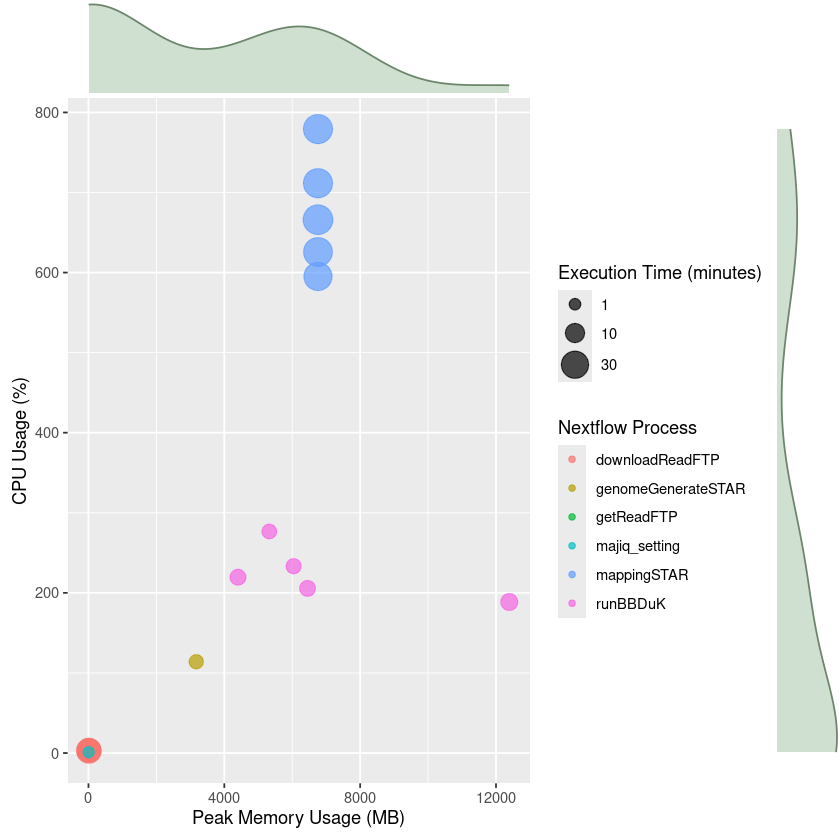

In [18]:
resources_plot <- ggplot(trace_data_processed,
                         aes(x = peak_rss_mb, y = cpu_percent)) +
  geom_point(
    aes(
      color = process,
      size = duration_min
    ),
    alpha = 0.7
  ) +
  scale_size_continuous(
    range = c(2, 8),
    breaks = c(1, 10, 30, 60, 120, 240),
    name = "Execution Time (minutes)"
  ) +
  labs(
    x = "Peak Memory Usage (MB)",
    y = "CPU Usage (%)",
    color = "Nextflow Process"
  ) +
  theme_gray() +
  theme(legend.position = "right")

summary_resource_plot <- ggMarginal(
  resources_plot,
  type = "density",
  margins = "both",
  fill = "#bcd3bc",
  col = "#6b866b",
  alpha = 0.7,
  size = 7
)

print(summary_resource_plot)

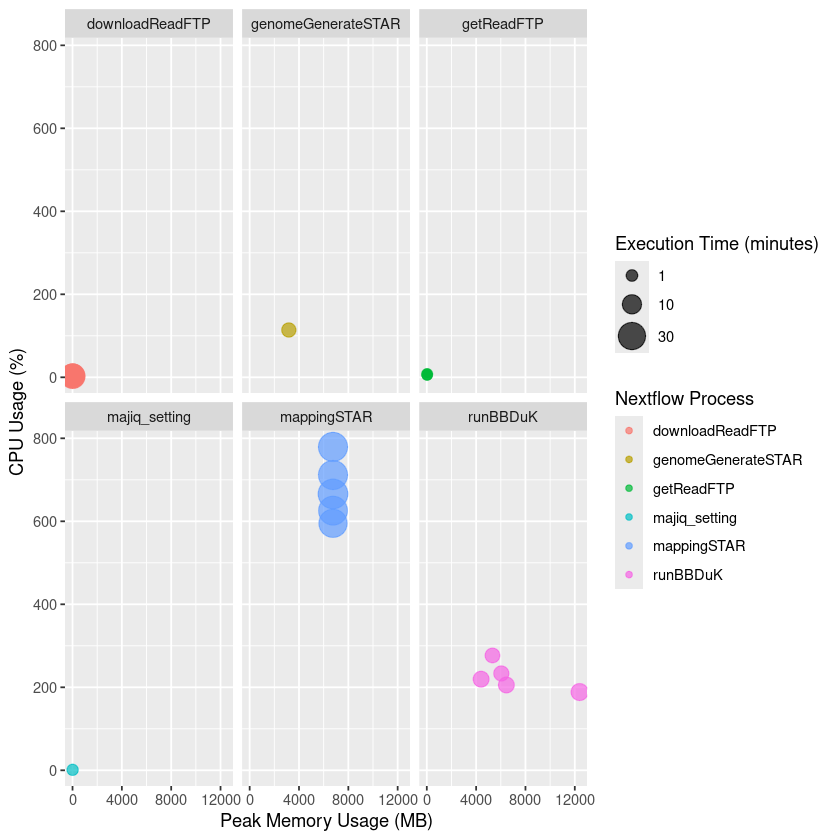

In [19]:
resources_plot +
  facet_wrap(~ process)